# A-Band Fitting Using HAPI MultiSpectrum fitting
* Loads packages
* Defines Spectra and Dataset
* Generates parameter and baseline linelists
* Fits Data

In [1]:
## Multi- Spectrum Fitting by Segment

import numpy as np
import numpy.ma as ma
import pandas as pd
import qgrid
import os
from lmfit import minimize, Parameters, report_fit, Model, Minimizer
from lmfit.models import GaussianModel, LinearModel, Model, VoigtModel
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy import interpolate

import sys
sys.path.append(r'C:\Users\ema3\Documents\HAPI-spectral-fitting\From DataFrame')# set location of HAPI.py module
%matplotlib inline
from hapi import *
from HAPI_MultispectrumFitting import *

import seaborn as sns
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("poster")


HAPI version: 1.1.0.9.6
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005


## Load Spectrum

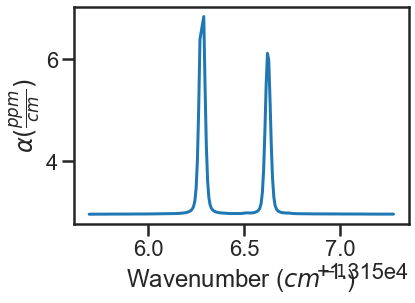

In [2]:
path = r'C:\Users\ema3\Documents\HAPI-spectral-fitting\From DataFrame\Examples\A-Band - Experimental Spectra'
os.chdir(path)

#Generic Fit Parameters
wave_range = 1.5 #range outside of experimental x-range to simulate
IntensityThreshold = 1e-30 #intensities must be above this value to be simulated
Fit_Intensity = 1e-24 #intensities must be above this value for the line to be fit
order_baseline_fit = 1
tau_column = 'Corrected Tau (us)' # Mean tau/us
freq_column = 'Total Frequency (Detuning)' # Total Frequency /MHz
pressure_column = 'Cavity Pressure /Torr'
temperature_column = 'Cavity Temperature Side 2 /C'


#Define all Spectra individually
spec_1 = Spectrum('190510_2per_43_forfit', 
                        molefraction = { 7 :0.01949}, natural_abundance = True, diluent = 'air', 
                        etalons = {1:[0.001172, 1.19574]}, 
                        input_freq = True, frequency_column = freq_column,
                        input_tau = True, tau_column = tau_column, tau_stats_column = None, 
                        pressure_column = pressure_column, temperature_column = temperature_column, 
                        nominal_temperature = 296, x_shift = 0.00)
spec_2 = Spectrum('190510_2per_55_forfit', 
                        molefraction = { 7 : 0.01949}, natural_abundance = True, diluent = 'air', 
                        etalons = {1:[0.001172, 1.19574]}, 
                        input_freq = True, frequency_column = freq_column,
                        input_tau = True, tau_column = tau_column, tau_stats_column = None, 
                        pressure_column = pressure_column, temperature_column = temperature_column, 
                        nominal_temperature = 296, x_shift = 0.00)
spec_3 = Spectrum('190513_2per_82_forfit', 
                        molefraction = { 7 :0.01949}, natural_abundance = True, diluent = 'air', 
                        etalons = {1:[0.001172, 1.19574]}, 
                        input_freq = True, frequency_column = freq_column,
                        input_tau = True, tau_column = tau_column, tau_stats_column = None, 
                        pressure_column = pressure_column, temperature_column = temperature_column, 
                        nominal_temperature = 296, x_shift = 0.00)
spec_4 = Spectrum('190514_2per_126_forfit', 
                        molefraction = { 7 :0.01949}, natural_abundance = True, diluent = 'air', 
                        etalons = {1:[0.001172, 1.19574]}, 
                        input_freq = True, frequency_column = freq_column,
                        input_tau = True, tau_column = tau_column, tau_stats_column = None, 
                        pressure_column = pressure_column, temperature_column = temperature_column, 
                        nominal_temperature = 296, x_shift = 0.00)



spec_1.plot_wave_alpha()



## Construct Dataset

In [3]:
#Add all spectrum to a Dataset object
SPECTRA = Dataset([spec_1, spec_2, spec_3, spec_4], 'Line Intensity', baseline_order = order_baseline_fit)

#Generate Baseline Parameter list based on number of etalons in spectra definitions and baseline order
BASE_LINELIST = SPECTRA.generate_baseline_paramlist()
#BASE_LINELIST = pd.read_csv('Line Intensity_baseline_paramlist.csv')

#Read in Possible linelists
hapi = r'C:\Users\ema3\Documents\HAPI-spectral-fitting\From DataFrame\Linelists'
os.chdir(hapi)
PARAM_LINELIST = pd.read_csv('O2_ABand_Drouin_2017_linelist.csv')



## Generate Fit Parameter Files

In [4]:
os.chdir(path)
# Set-up for Fitting
#lineprofile = 'NGP' #VP, SDVP, NGP, SDNGP, HTP


  

FITPARAMS = Generate_FitParam_File(SPECTRA, PARAM_LINELIST, BASE_LINELIST, lineprofile = 'SDVP', linemixing = False, 
                                  fit_intensity = Fit_Intensity, threshold_intensity = IntensityThreshold, sim_window = wave_range,
                                  nu_constrain = False, sw_constrain = False, gamma0_constrain = True, delta0_constrain = True, 
                                   aw_constrain = True, as_constrain = True, 
                                   nuVC_constrain = True, eta_constrain =True, linemixing_constrain = True)

FITPARAMS.generate_fit_param_linelist_from_linelist(vary_nu = {7:{1:True, 2:False, 3:False}}, vary_sw = {7:{1:True, 2:False, 3:False}},
                                                    vary_gamma0 = {7:{1: True, 2:False, 3: False}, 1:{1:False}}, vary_n_gamma0 = {7:{1:True}}, 
                                                    vary_delta0 = {7:{1: False, 2:False, 3: False}, 1:{1:False}}, vary_n_delta0 = {7:{1:True}}, 
                                                    vary_aw = {7:{1: True, 2:False, 3: False}, 1:{1:False}}, vary_n_gamma2 = {7:{1:False}}, 
                                                    vary_as = {}, vary_n_delta2 = {7:{1:False}}, 
                                                    vary_nuVC = {7:{1:False}}, vary_n_nuVC = {7:{1:False}},
                                                    vary_eta = {}, vary_linemixing = {7:{1:False}})

FITPARAMS.generate_fit_baseline_linelist(vary_baseline = True, vary_molefraction = {7:False, 1:False}, vary_xshift = False, 
                                      vary_etalon_amp= True, vary_etalon_freq= False, vary_etalon_phase= True)





,Pressure,Pressure_err,Pressure_vary,Segment Number,Temperature,Temperature_err,Temperature_vary,baseline_a,baseline_a_err,baseline_a_vary,...,etalon_1_freq_vary,etalon_1_phase,etalon_1_phase_err,etalon_1_phase_vary,molefraction_O2,molefraction_O2_err,molefraction_O2_vary,x_shift,x_shift_err,x_shift_vary
Spectrum Number,,,,,,,,,,,,,,,,,,,,,
1.0,0.079111,0,False,1.0,297.903746,0,False,2.957091,0,True,...,False,0.0,0,True,0.01949,0,False,0.0,0,False
2.0,0.065558,0,False,1.0,297.908245,0,False,2.959480,0,True,...,False,0.0,0,True,0.01949,0,False,0.0,0,False
3.0,0.046017,0,False,1.0,297.876303,0,False,2.956829,0,True,...,False,0.0,0,True,0.01949,0,False,0.0,0,False
4.0,0.024884,0,False,1.0,297.864910,0,False,2.949260,0,True,...,False,0.0,0,True,0.01949,0,False,0.0,0,False


Name                     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Pressure_1_1           0.07911     -inf      inf        0    False     None     None
Pressure_2_1           0.06556     -inf      inf        0    False     None     None
Pressure_3_1           0.04602     -inf      inf        0    False     None     None
Pressure_4_1           0.02488     -inf      inf        0    False     None     None
SD_delta_air_line_1          0     -inf      inf        0    False     None     None
SD_delta_air_line_10         0     -inf      inf        0    False     None     None
SD_delta_air_line_13         0     -inf      inf        0    False     None     None
SD_delta_air_line_25         0     -inf      inf        0    False     None     None
SD_delta_air_line_26         0     -inf      inf        0    False     None     None
SD_gamma_air_line_1        0.1     0.05      0.2        0    False     None     None
SD_gamma_air_line_10    0.1142     0.04     0.16 0.000825     T

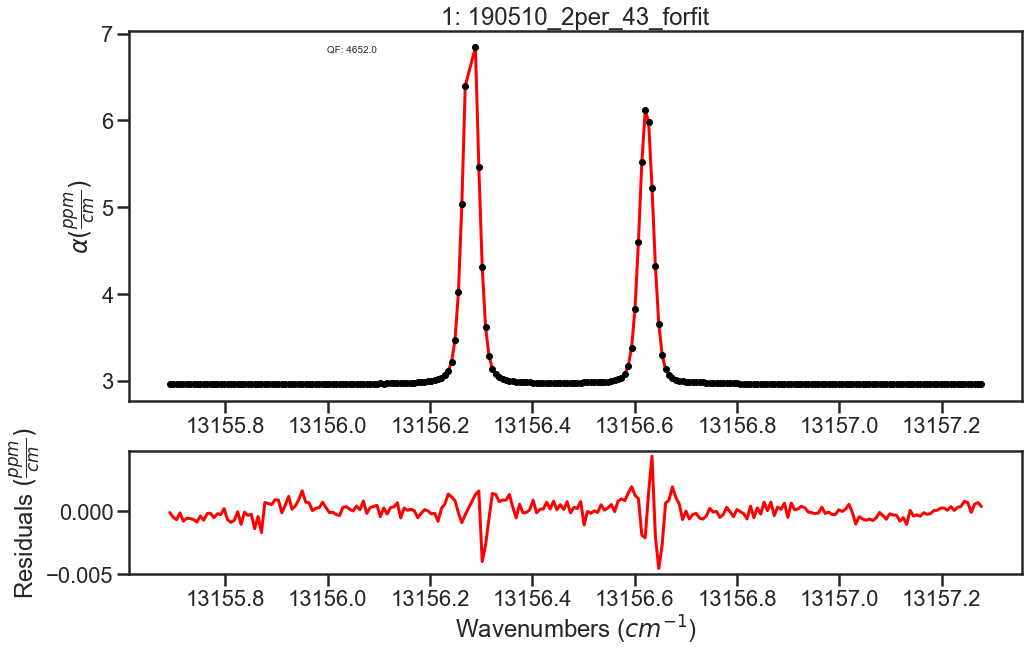

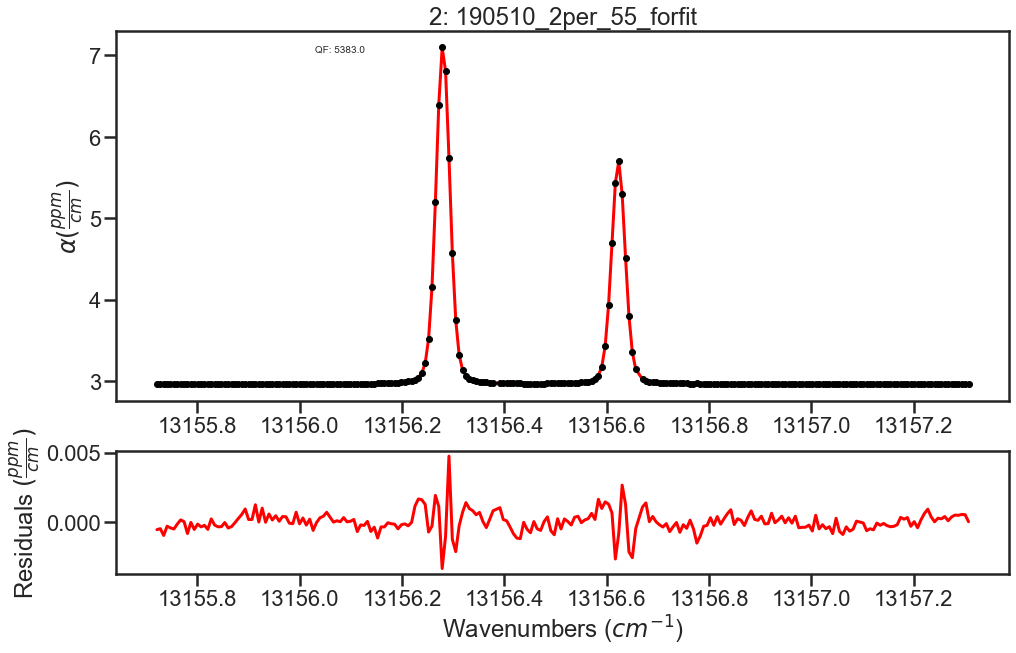

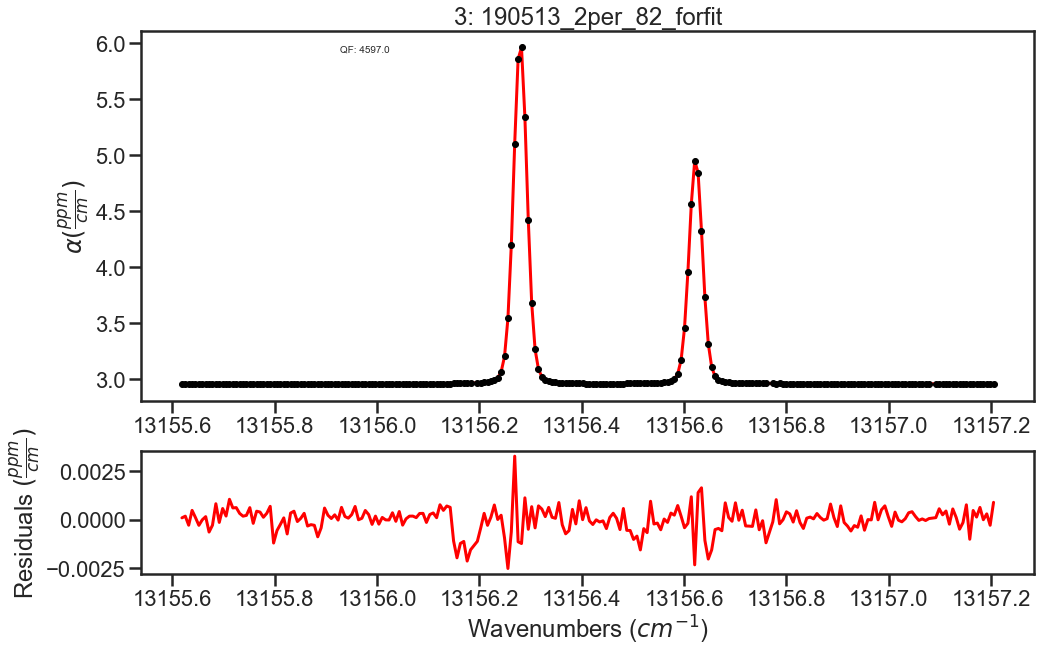

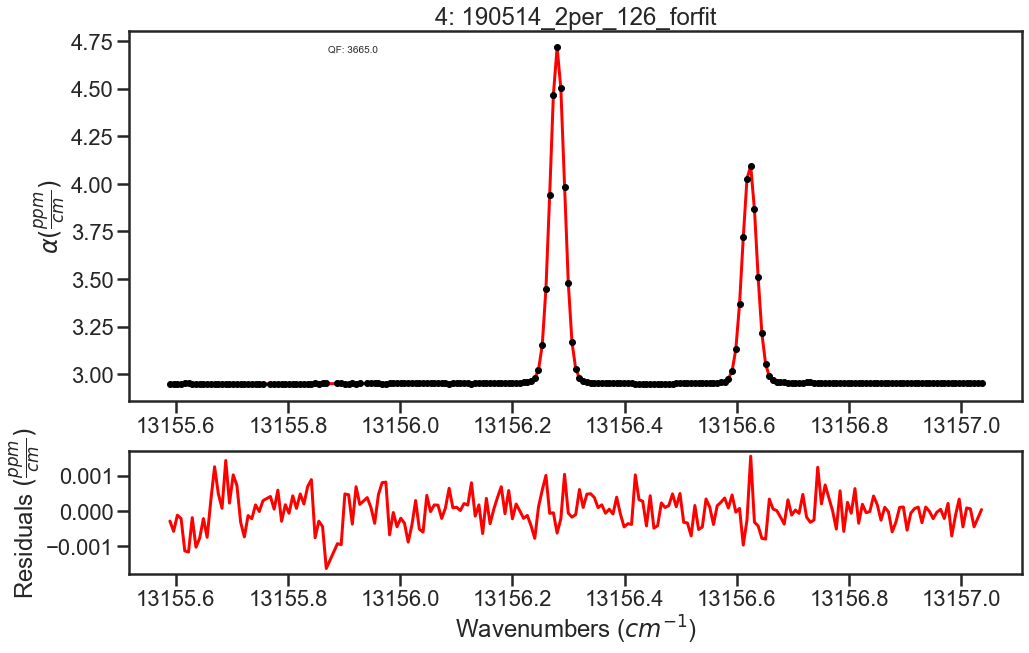

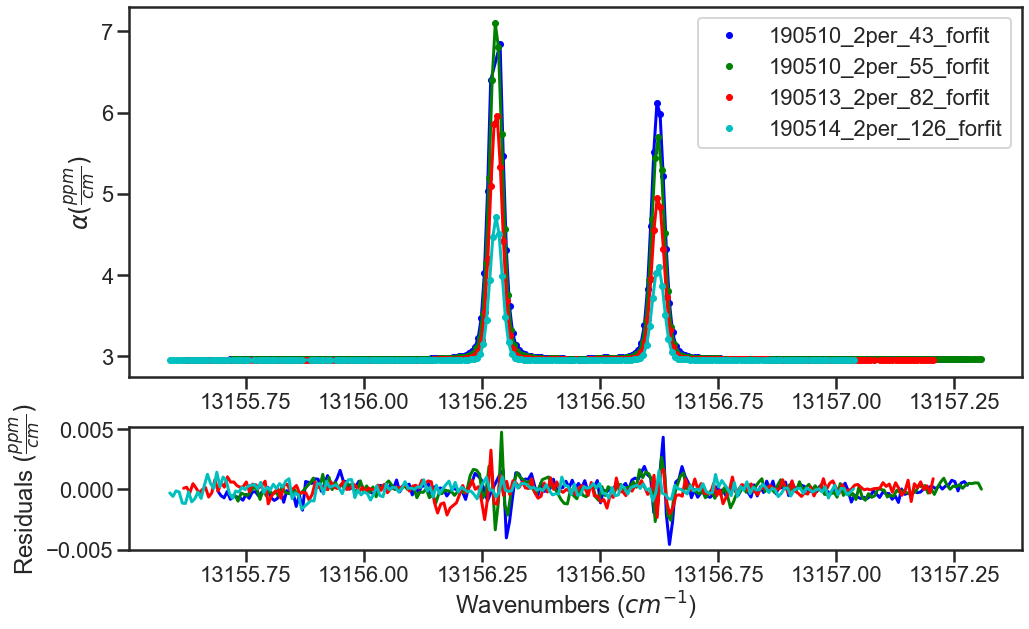

In [5]:
os.chdir(path)   
fit_data = Fit_DataSet(SPECTRA,'Baseline_LineList', 'Parameter_LineList', minimum_parameter_fit_intensity = Fit_Intensity, 
                baseline_limit = False, baseline_limit_factor = 10, 
                molefraction_limit = True, molefraction_limit_factor = 1.1, 
                etalon_limit = False, etalon_limit_factor = 2, #phase is constrained to +/- 2pi, 
                x_shift_limit = True, x_shift_limit_magnitude = 0.5, 
                nu_limit = True, nu_limit_magnitude = 0.1, 
                sw_limit = True, sw_limit_factor = 2, 
                gamma0_limit = True, gamma0_limit_factor = 3, n_gamma0_limit= False, n_gamma0_limit_factor = 50, 
                delta0_limit = True, delta0_limit_factor = 2, n_delta0_limit = False, n_delta0_limit_factor = 50, 
                SD_gamma_limit = True, SD_gamma_limit_factor = 2, n_gamma2_limit = False, n_gamma2_limit_factor = 50, 
                SD_delta_limit = True, SD_delta_limit_factor = 50, n_delta2_limit = False, n_delta2_limit_factor = 50, 
                nuVC_limit = False, nuVC_limit_factor = 2, n_nuVC_limit = False, n_nuVC_limit_factor = 50, 
                eta_limit = True, eta_limit_factor = 50, linemixing_limit = False, linemixing_limit_factor = 50)
params = fit_data.generate_params()
#params['etalon_2_freq_1'].set(expr='2*etalon_1_freq_1')
#params['etalon_2_phase_1'].set(expr='etalon_1_phase_1')


for param in params:
    if 'n_gamma2' in param:
        newparam = param.replace('n_gamma2', 'n_gamma0')
        params[param].set(expr = newparam)



#print (params)

#add_expr_params(self, params, param_name, expr)

result = fit_data.fit_data(params, wing_cutoff = 25, wing_wavenumbers = 1)
print (result.params.pretty_print())

fit_data.residual_analysis(result, indv_resid_plot=True)
fit_data.update_params(result)
SPECTRA.generate_summary_file(save_file = True)
SPECTRA.plot_model_residuals()




    Frequency  Amplitude     Phase  Freq (cm-1)
0    7.708447   0.000171  2.363220     0.129728
1   72.879863   0.000137 -1.481723     0.013721
2    8.409215   0.000132  0.956233     0.118917
3    9.109983   0.000126  0.316063     0.109770
4    4.905375   0.000125  2.467588     0.203858
5   48.352986   0.000121  1.192186     0.020681
6   14.015358   0.000117 -1.230273     0.071350
7   12.613823   0.000115 -0.839986     0.079278
8   24.526877   0.000112  1.453314     0.040772
9   63.069113   0.000111  2.734000     0.015856
10  30.133020   0.000110 -2.435095     0.033186
11   2.102304   0.000108 -2.510908     0.475669
12  15.416894   0.000105  2.455004     0.064864
13  23.826109   0.000102 -1.034695     0.041971
14  40.644539   0.000100  1.246425     0.024604
15  47.652218   0.000099  2.180203     0.020985
16  50.455290   0.000099  0.663809     0.019820
17  33.636860   0.000095  0.604965     0.029729
18  53.959130   0.000092 -1.452529     0.018533
19   2.803072   0.000087 -2.451535     0

C:\Users\ema3\Documents\HAPI-spectral-fitting\From DataFrame\HAPI_MultispectrumFitting.py:340: RuntimeWarning: divide by zero encountered in true_divide
  FFT['Freq (cm-1)'] = 1 / fft_freq
C:\Users\ema3\Documents\HAPI-spectral-fitting\From DataFrame\HAPI_MultispectrumFitting.py:345: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1 / fft_freq, fft_amplitude, '-')


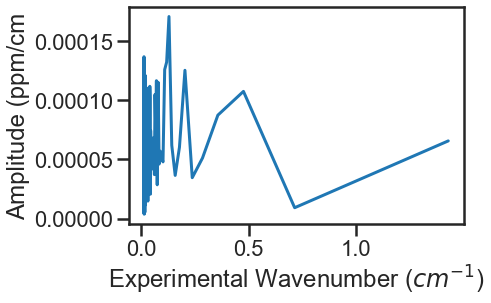

60.12449576029981 24.753745681682346
49.82397842220005 24.75824458315128
34.97316375429999 24.726303350025262
18.912206300500088 24.714909894025595


In [6]:
spec_4.fft_spectrum()


s_list = [spec_1, spec_2, spec_3, spec_4]
for s in s_list:
    
    print (s.get_pressure_torr(), s.get_temperature_C())



